This notebook combines Bernie Raucsher, Jarron Leisenring, and Kevin Volk's noise generation analysis for NIRSpec, NIRCam, and NIRISS, respectively.

Here we are trying to reproduce Figure 2 from Rauscher 2015 with NIRISS specific data

In [1]:
%matplotlib inline
import os

import numpy as np
import nghxrg as ng

from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from time import time
from scipy import signal
from astropy.io import fits

In [2]:
os.environ['NGHXRG_HOME'] = '../nghxrg/'

In [3]:
plt.rcParams['figure.dpi'] = 150

In [4]:
cpu_count()

8

In [5]:
def plot_fft_with_window(xdata, ydata, fStart = 1, normed = True, \
                         logtype='semi', ax = None, Plot = False, **kwargs):
    '''
        >>> # Number of samplepoints
        >>> N = 600
        >>> # sample spacing
        >>> T = 1.0 / 800.0
        >>> x = np.linspace(0.0, N*T, N)
        >>> y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
    '''
    from scipy.fftpack import fft
    from scipy.signal import blackmanharris as blackman
    import matplotlib.pyplot as plt
    
    nData       = ydata.size
    
    if fStart > nData/2:
        raise Exception("fStart must be less than nData/2 or there won't be anything to plot")
    
    spacing     = np.median(np.diff(xdata))
    ydata_fft   = fft(ydata)
    
    window      = blackman(nData)
    ydata_wfft  = fft(ydata*window)
    
    frequencies = np.linspace(0.0, 1.0/(2.0*spacing), nData/2)
    frequencies = frequencies[fStart:nData//2]
    PSD         = 2.0/nData * np.abs(ydata_wfft[fStart:nData//2])
    
    if Plot and ax is None:
        fig = plt.gcf()
        ax  = fig.add_subplot(111)
    if Plot and 'semi' in logtype:
        ax.semilogy(frequencies, PSD, '-', label='FFT Window', **kwargs)
    if Plot and 'loglog' in logtype:
        ax.loglog(  frequencies, PSD, '-', label='FFT Window', **kwargs)
    
    return frequencies, PSD

In [6]:
def make_cds_and_compute_psd(instance, o_file='dummy.fits', nout=4, readTime=10e-6, flipOdd=True):
    
    nyquistSampling = 0.5
    
    hdu     = instance.mknoise(o_file)
    ny,nx   = hdu.data[1].shape
    ampSize = nx // nout
    
    cds     = (hdu.data[-1] - hdu.data[0])#.reshape([nout, ny*nx/nout])
    
    readpaths = []
    # Flip odd amplfiers
    for k in range(nout):
        if k %2 and flipOdd:
            cds[k*ampSize:(k+1)*ampSize] = cds[k*ampSize:(k+1)*ampSize][::-1]
        
        readpaths.append(cds[k*ampSize:(k+1)*ampSize].flatten())
    
    del hdu
    
    freqs   = []
    PSDs    = []
    maxFreq = nyquistSampling / readTime
    
    for amp in readpaths:
        freqsNow, PSDnow = signal.periodogram(amp, maxFreq, window='bartlett', scaling='density');
        freqs.append(freqsNow)
        PSDs.append(PSDnow)
        del freqsNow, PSDnow
    
    del cds
    
    freqs = np.squeeze(freqs)
    PSDs  = np.squeeze(PSDs)
    
    return np.array([freqs, PSDs])

In [7]:
ny, nx   = 2048, 2048
ngroups  = 2 # Number of groups up the ramp
nout     = 4 # Number of amplifier output channels

nframes  = 400 # number of CDS integrations to processes

ng_h2rg  = ng.HXRGNoise(naxis1=nx, naxis2=ny, n_out=nout, naxis3=ngroups)

# outputs = make_cds_and_compute_psd(ng_h2rg)

In [8]:
start   = time()
nCores  = 8
pool    = Pool(nCores)

freqs_psds = pool.starmap(partial(make_cds_and_compute_psd, flipOdd=False), zip([ng_h2rg]*nframes))

pool.close()
pool.join()
print('Operation took {} seconds'.format(time()-start))

Operation took 1981.4514627456665 seconds


In [9]:
freqsList, psdsList = [], []
for freq_psd in freqs_psds:
    freqs4, psds4 = freq_psd
    for freqAmp,psdAmp in zip(freqs4, psds4):
        freqsList.append(freqAmp)
        psdsList.append(psdAmp)

In [10]:
freqsArr = np.array(freqsList)
psdsArr  = np.array(psdsList)

In [11]:
freqsMaster = np.mean(freqsArr,axis=0)
PSDMaster = np.mean(psdsArr,axis=0)

In [12]:
nData       = nout*nframes*PSDMaster.size

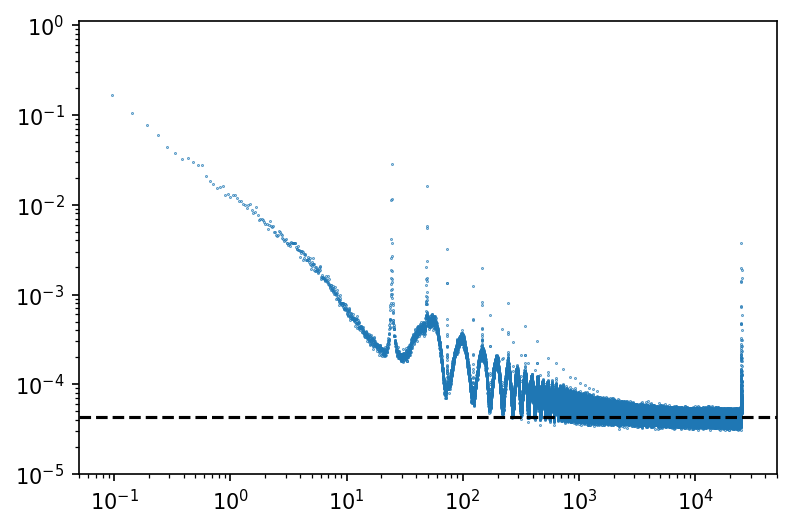

In [28]:
plt.rcParams['figure.dpi'] = 150
# fig = plt.figure(figsize=(2,5))
fig = plt.gcf()
ax  = fig.add_subplot(111)
# ax.scatter(freqsArr[0], psdsArr[0]/(nout*nframes*psdsArr[0].size) , s=.1, label='FFT Avg {} CDS'.format(nframes-1));
# ax.scatter(freqsArr[:5].mean(axis=0), psdsArr[:5].mean(axis=0)/(nout*nframes*psdsArr[0].size) , s=.1, label='FFT Avg {} CDS'.format(nframes-1));
# ax.scatter(freqsArr[:10].mean(axis=0), psdsArr[:10].mean(axis=0)/(nout*nframes*psdsArr[0].size) , s=.1, label='FFT Avg {} CDS'.format(nframes-1));
# ax.scatter(freqsArr[:25].mean(axis=0), psdsArr[:25].mean(axis=0)/(nout*nframes*psdsArr[0].size) , s=.1, label='FFT Avg {} CDS'.format(nframes-1));
# ax.scatter(freqsArr[:50].mean(axis=0), psdsArr[:50].mean(axis=0)/(nout*nframes*psdsArr[0].size) , s=.1, label='FFT Avg {} CDS'.format(nframes-1));
# ax.scatter(freqsArr[:75].mean(axis=0), psdsArr[:75].mean(axis=0)/(nout*nframes*psdsArr[0].size) , s=.1, label='FFT Avg {} CDS'.format(nframes-1));
ax.scatter(freqsMaster, PSDMaster/nData , s=.1, label='FFT Avg {} CDS'.format(nframes-1));
ax.set_ylim(1e-5,1.1);
ax.set_xlim(.05,5e4);
ax.set_yscale('log');
ax.set_xscale('log');
# ax.axhline(1e-5, color='black', ls='--');
# ax.axhline(2e-5, color='black', ls='--');
ax.axhline(4.3069993903350501e-05, color='black', ls='--');

In [35]:
10**(np.log10(freqsMaster[useFreqs]).mean())

13752.708330244761

In [36]:
np.sqrt(4.3069993903350501e-05*13752.708330244761/2)

0.54421000722983748

In [39]:
useFreqs = (freqsMaster > 5e3)*(freqsMaster < 4e4)
np.trapz(PSDMaster[useFreqs]/nData, freqsMaster[useFreqs]) / np.trapz(np.ones(useFreqs.sum()), freqsMaster[useFreqs])

4.3069993903350501e-05

**GATPSY Pink Noise Test**